In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1675735640756383889, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10078500699093318908
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13319782710648441888
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11326753997
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5480722384428842812
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [39]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

"""
# Create simple model
from keras.layers import Conv2D, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, 5, activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(128, 5, activation='relu', padding='same'))
model.add(Conv2D(1, 5, activation='sigmoid', padding='same'))
model.add(Reshape((128, 128)))
          
model.compile(Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])     
"""


def unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    outputs = Reshape((128,128))(outputs)
    
    model = Model(input = inputs, output = outputs)
    
    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
    #smaller learning rate seems to work better (1e-4 vs 1e-2)
    
    return model



In [40]:
from glob import glob
import os

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])


path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print(val_img_paths[:5])

['train/53717_sat.jpg', 'train/12320_sat.jpg', 'train/53640_sat.jpg', 'train/12480_sat.jpg', 'train/27456_sat.jpg', 'train/40397_sat.jpg', 'train/34417_sat.jpg', 'train/24192_sat.jpg', 'train/42547_sat.jpg', 'train/18984_sat.jpg']
['train/52857_msk.png', 'train/5009_msk.png', 'train/29412_msk.png', 'train/50596_msk.png', 'train/8066_msk.png', 'train/11225_msk.png', 'train/43068_msk.png', 'train/48526_msk.png', 'train/47933_msk.png', 'train/15692_msk.png']
['val/76232_sat.jpg', 'val/71058_sat.jpg', 'val/73690_sat.jpg', 'val/79306_sat.jpg', 'val/74502_sat.jpg']


In [41]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(128, 128)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) / 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

In [42]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []

In [43]:
model = unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 128, 128, 16) 448         input_10[0][0]                   
__________________________________________________________________________________________________
dropout_82 (Dropout)            (None, 128, 128, 16) 0           conv2d_175[0][0]                 
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 128, 128, 16) 2320        dropout_82[0][0]                 
__________________________________________________________________________________________________
max_poolin

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [44]:
from sklearn.model_selection import train_test_split

BATCHSIZE = 32

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=5, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5  # Change this number based on memory restrictions
)

Epoch 1/5


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


290/290 [==============================] - 275s 949ms/step - loss: 0.9832 - dice_coef: 0.0390 - val_loss: 0.8931 - val_dice_coef: 0.2177
Epoch 2/5
290/290 [==============================] - 272s 938ms/step - loss: 0.7972 - dice_coef: 0.3159 - val_loss: 0.6966 - val_dice_coef: 0.4028
Epoch 3/5
290/290 [==============================] - 269s 927ms/step - loss: 0.6835 - dice_coef: 0.4203 - val_loss: 0.6051 - val_dice_coef: 0.4864
Epoch 4/5
290/290 [==============================] - 270s 929ms/step - loss: 0.6272 - dice_coef: 0.4694 - val_loss: 0.5674 - val_dice_coef: 0.5207
Epoch 5/5
290/290 [==============================] - 269s 926ms/step - loss: 0.5899 - dice_coef: 0.5024 - val_loss: 0.5478 - val_dice_coef: 0.5402


In [90]:
import numpy as np
import pandas as pd

# Create submission DataFrame
def create_submission(csv_name, predictions_gen):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> generator that yields a pair of id, prediction
    """
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(val_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        #print (np.count_nonzero(pred == 1))
        encodings.append(rle_encoding(pred))
        
    sub['EncodedPixels'] = encodings
    sub['ImageId'] = ids
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [91]:

def generate_pixel_by_pixel_predictions_generator(val_paths):
    for img_path in val_paths:        
        img = imread(img_path) / 255.
        img = resize(img, (128, 128), preserve_range=True)    
        y = model.predict(img.reshape(1,128,128,3))  
        y = (y >= 0.5).astype(float) #IMPORTANT- need this or you won't have 0 or 1 (because outputs are probabilities!!)
        yield get_img_id(img_path), y.reshape(128, 128)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


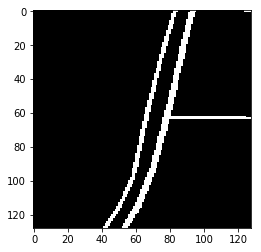

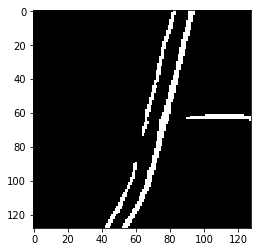

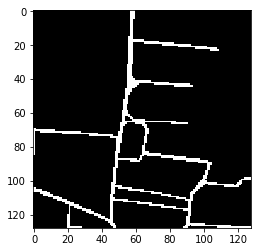

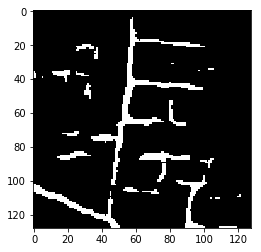

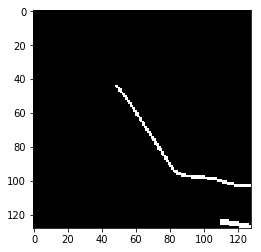

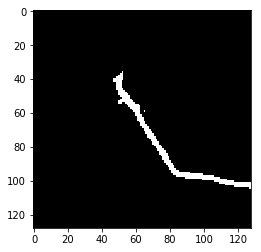

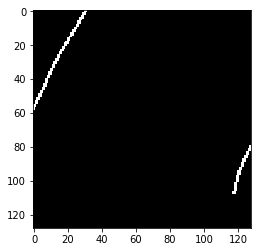

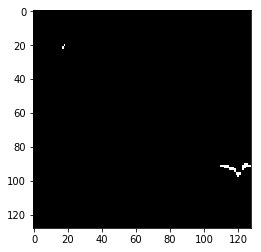

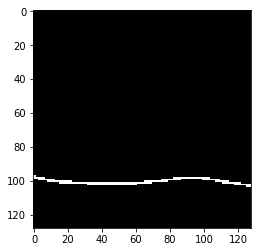

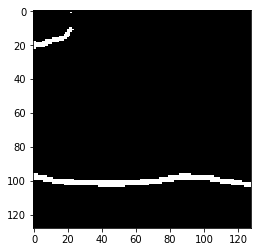

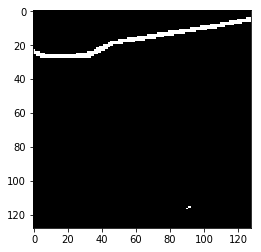

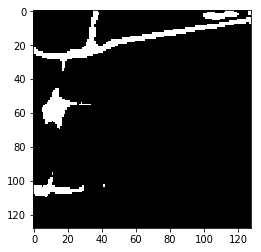

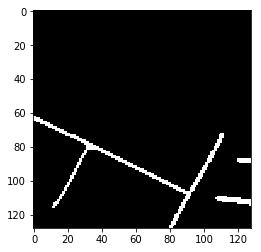

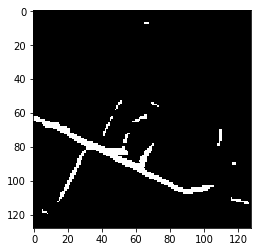

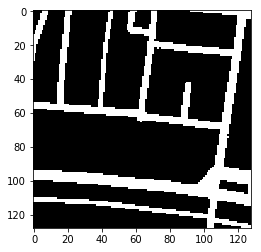

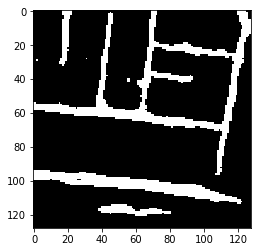

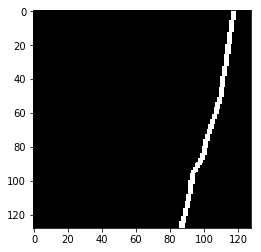

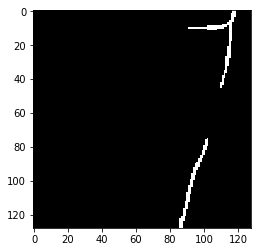

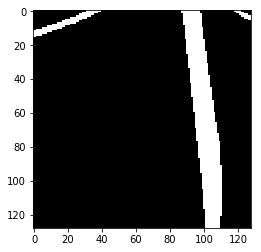

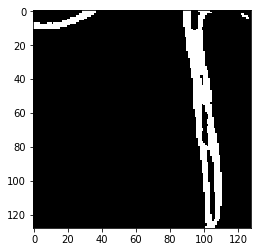

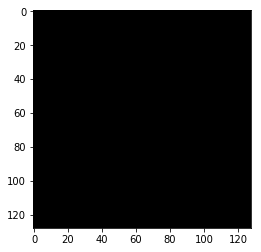

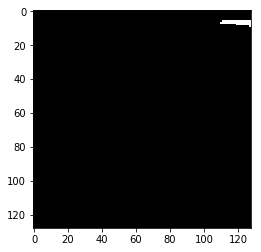

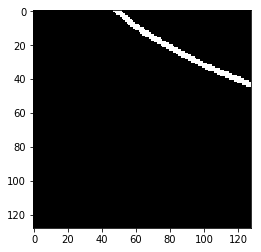

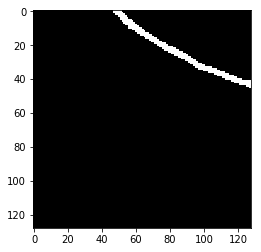

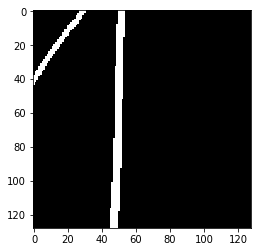

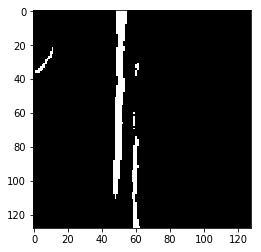

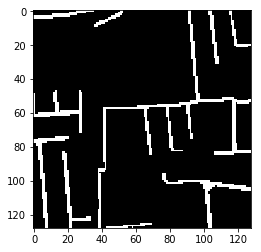

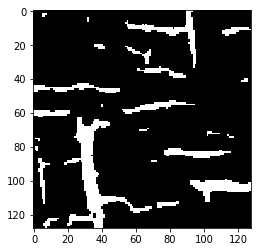

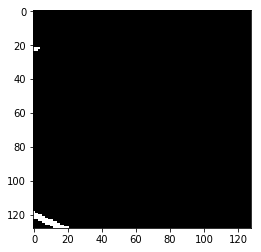

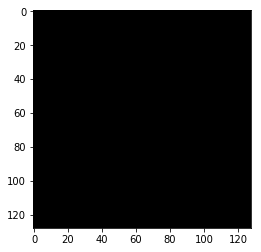

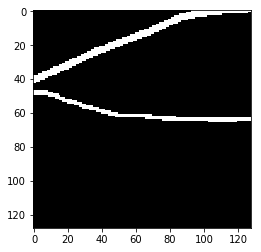

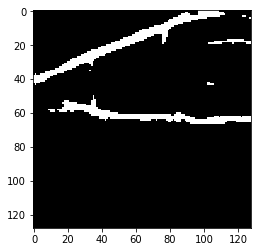

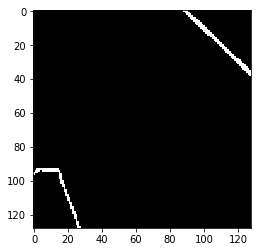

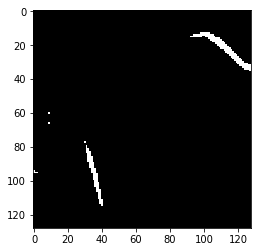

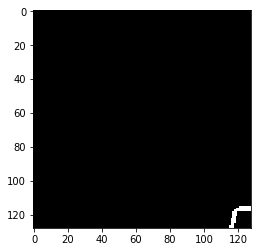

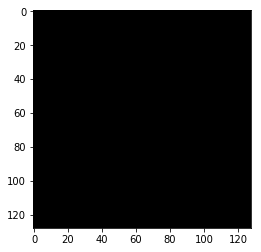

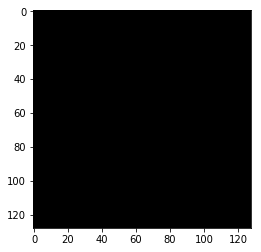

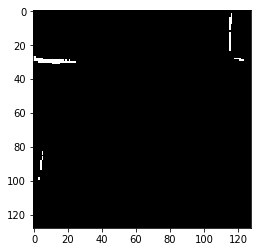

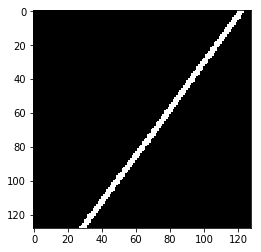

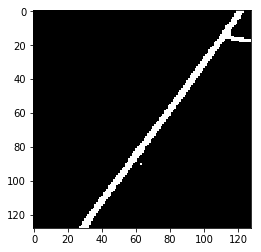

'\ntic = time.time()\ncreate_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))\ntoc = time.time()\nprint(toc - tic)\n'

In [94]:
import time
import matplotlib.pyplot as plt
path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')
train_img_paths = glob(glob_train_imgs)
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)


#first_img, first_mask = next(ig)
img_size = (128,128)
for i in range(20): 
    
    img_id = get_img_id(train_img_paths[i])
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
           
    img = imread(train_img_paths[i]) / 255.
    mask = rgb2gray(imread(mask_path))
    img = resize(img, img_size, preserve_range=True)
    mask = resize(mask, img_size, mode='constant', preserve_range=True)    
    mask = (mask >= 0.5).astype(float)
    
    plt.imshow(mask, cmap='gray')
    plt.show()
    
    y = model.predict(img.reshape(1,128,128,3)) 
    y = (y.reshape(128,128) >= 0.5).astype(float)
    
    plt.imshow(y, cmap='gray')
    plt.show()
    
    
    """
    img = imread(val_img_paths[i]) / 255.
    img = resize(img, (128, 128), preserve_range=True)  
    print (get_img_id(val_img_paths[i]))
    y = model.predict(img.reshape(1,128,128,3)) 
    y = (y >= 0.5).astype(float)
    print (np.count_nonzero(y == 1))
    #print (y)
    #plt.imshow(y.reshape(128,128), cmap='gray')
    #plt.show()
    """

"""
tic = time.time()
create_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))
toc = time.time()
print(toc - tic)
"""
